In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0030912.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0028933.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0030585.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0028394.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0033697.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0030062.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0031213.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0027799.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0028100.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0027960.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0028872.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0031317.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0033841.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0026412.jpg
/kaggle/input/ham10000-googlenet/HAM10000_images/ISIC_0033096.jpg
/kaggle/in

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,precision_recall_curve,classification_report
from keras.applications import InceptionV3
from keras.layers import Conv2D,Dense, GlobalAveragePooling2D,MaxPooling2D,Flatten,Dropout
from keras.models import Model , Sequential
from keras.optimizers import SGD,Adam,RMSprop
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_visible_devices(gpus, 'GPU')

In [5]:
train_img='/kaggle/input/ham10000-googlenet/HAM10000_images'
data=pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv",usecols=['image_id','dx'])

In [6]:
data.head(5)

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [7]:
data.describe()

,image_id,dx
count,10015,10015
unique,10015,7
top,ISIC_0027419,nv
freq,1,6705


In [8]:
df=pd.DataFrame()

# reading taking only 100 images belonging to each class
labels=data['dx'].unique()
for label in labels:
  label_df=data[data['dx']==label]
  label_df=label_df.sample(350,random_state=42,replace=True)
  df=pd.concat([df,label_df])
df=df.sample(frac=1,random_state=42)

df.describe()

,image_id,dx
count,2450,2450
unique,1624,7
top,ISIC_0031443,mel
freq,12,350


In [9]:
df['image_path']=df['image_id'].apply(lambda x: os.path.join(train_img,x+'.jpg'))
df=df.drop('image_id',axis=1)
df.head(3)

,dx,image_path
2026,mel,/kaggle/input/ham10000-googlenet/HAM10000_imag...
1118,df,/kaggle/input/ham10000-googlenet/HAM10000_imag...
9754,akiec,/kaggle/input/ham10000-googlenet/HAM10000_imag...


In [10]:
df['image']=df['image_path'].apply(lambda x: cv2.imread(x))
df['image']=df['image'].apply(lambda x: np.array(cv2.resize(x,(227,227))))
df['image']=df['image']/255
df.head()

,dx,image_path,image
2026,mel,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.6313725490196078, 0.5607843137254902, 0.6..."
1118,df,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.611764705882353, 0.615686274509804, 0.768..."
9754,akiec,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.6, 0.5529411764705883, 0.6784313725490196..."
9596,nv,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.8470588235294118, 0.7647058823529411, 0.8..."
7366,nv,/kaggle/input/ham10000-googlenet/HAM10000_imag...,"[[[0.5803921568627451, 0.5294117647058824, 0.5..."


In [11]:
le=LabelEncoder()
df['encoded_dx']=le.fit_transform(df['dx'])
df['encoded_dx'].value_counts()

encoded_dx
4    350
3    350
0    350
5    350
6    350
1    350
2    350
Name: count, dtype: int64

In [12]:
y=to_categorical(df['encoded_dx'])

In [13]:
x=np.array(df['image'].tolist())

In [14]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
#GoogleNet
base_model = InceptionV3(weights='imagenet', include_top=False)


87910968/87910968 [==============================] - 0s 0us/step


In [17]:
p = base_model.output
q = GlobalAveragePooling2D()(p)
r = Dense(512, activation='relu')(q)
s = Dropout(0.2)(r)
predictions = Dense(7, activation='softmax')(s)


In [18]:
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
batch_size = 30
epochs = 25

history = model.fit(datagen.flow(x_train, y_train),  # Use y_train_encoded
                            batch_size=batch_size, epochs=epochs,
                            validation_data=(x_test, y_test))  # Use y_test_encoded

Epoch 1/25
62/62 [==============================] - 54s 475ms/step - loss: 1.4462 - accuracy: 0.4622 - val_loss: 1.7758 - val_accuracy: 0.4367
Epoch 2/25
62/62 [==============================] - 22s 356ms/step - loss: 0.8587 - accuracy: 0.6852 - val_loss: 1.2689 - val_accuracy: 0.5510
Epoch 3/25
62/62 [==============================] - 22s 348ms/step - loss: 0.6223 - accuracy: 0.7755 - val_loss: 0.9365 - val_accuracy: 0.6898
Epoch 4/25
62/62 [==============================] - 22s 352ms/step - loss: 0.4661 - accuracy: 0.8316 - val_loss: 1.0492 - val_accuracy: 0.6898
Epoch 5/25
62/62 [==============================] - 22s 353ms/step - loss: 0.3946 - accuracy: 0.8648 - val_loss: 0.9465 - val_accuracy: 0.7347
Epoch 6/25
62/62 [==============================] - 22s 353ms/step - loss: 0.3349 - accuracy: 0.8786 - val_loss: 0.7547 - val_accuracy: 0.7816
Epoch 7/25
62/62 [==============================] - 22s 353ms/step - loss: 0.2885 - accuracy: 0.8959 - val_loss: 0.8647 - val_accuracy: 0.7796

In [21]:
# model evaluation
test_loss, test_accuracy = model.evaluate(x_test,y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
y_pred = model.predict(x_test)

16/16 [==============================] - 1s 67ms/step - loss: 1.2332 - accuracy: 0.7878
Test Loss: 1.2332, Test Accuracy: 0.7878
16/16 [==============================] - 2s 70ms/step


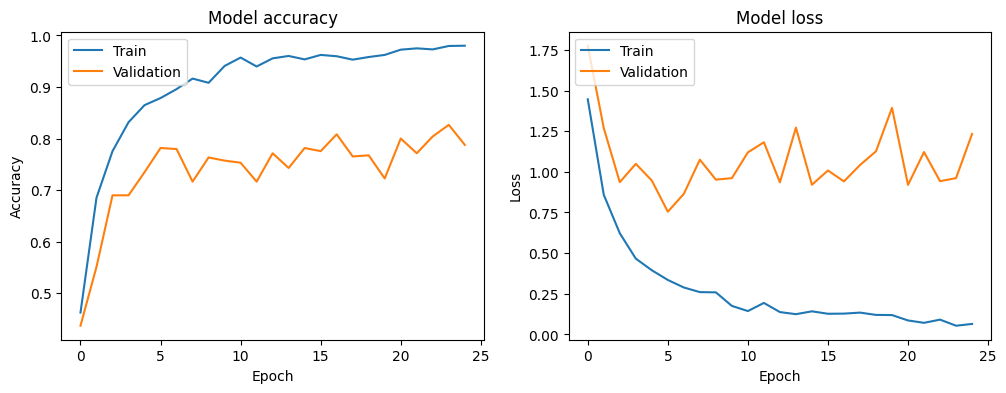

In [22]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [23]:
# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [24]:
# Generate a classification report
classification_rep = classification_report(y_true, y_pred, target_names=le.classes_)

In [25]:
# Print the classification report
print("Classification Report:\n", classification_rep)


Classification Report:
               precision    recall  f1-score   support

       akiec       0.82      0.81      0.81        67
         bcc       0.97      0.51      0.67        59
         bkl       0.65      0.78      0.71        79
          df       0.86      1.00      0.93        56
         mel       0.55      0.71      0.62        65
          nv       0.87      0.75      0.81        92
        vasc       0.99      0.96      0.97        72

    accuracy                           0.79       490
   macro avg       0.82      0.79      0.79       490
weighted avg       0.81      0.79      0.79       490

